In [ ]:
#---------------------LOADING THE DATASET---------------------
import pandas as pd

# Define column names
cols = ["ID", "Diagnosis"] + [
    "radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
    "compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean",
    "radius_se","texture_se","perimeter_se","area_se","smoothness_se",
    "compactness_se","concavity_se","concave_points_se","symmetry_se","fractal_dimension_se",
    "radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst",
    "compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"
]

# Read your .DATA file
df = pd.read_csv("wdbc.data", names=cols)

print(df.shape)
df.head()


(569, 32)


,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
#--------------------PREPROCESS------------------------------
from sklearn.preprocessing import StandardScaler

# 1. Drop ID column
df = df.drop("ID", axis=1)

# 2. Encode labels (M=1, B=0)
df["Diagnosis"] = df["Diagnosis"].map({"M":1, "B":0})

# 3. Handle missing values (if any)
df = df.dropna()   # removes rows with missing values

# 4. Separate features and labels
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X.shape, y.shape)


(569, 30) (569,)


Diagnosis
0    357
1    212
Name: count, dtype: int64


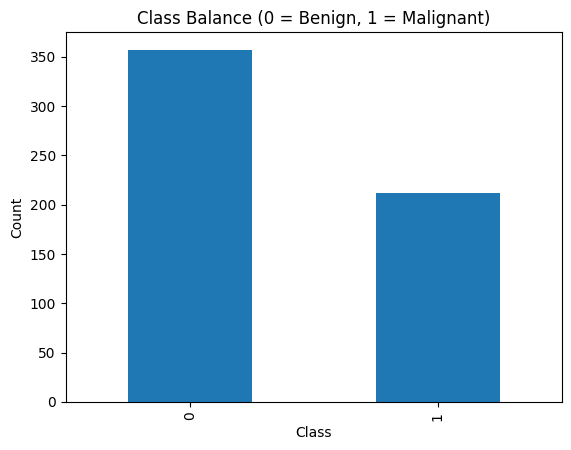

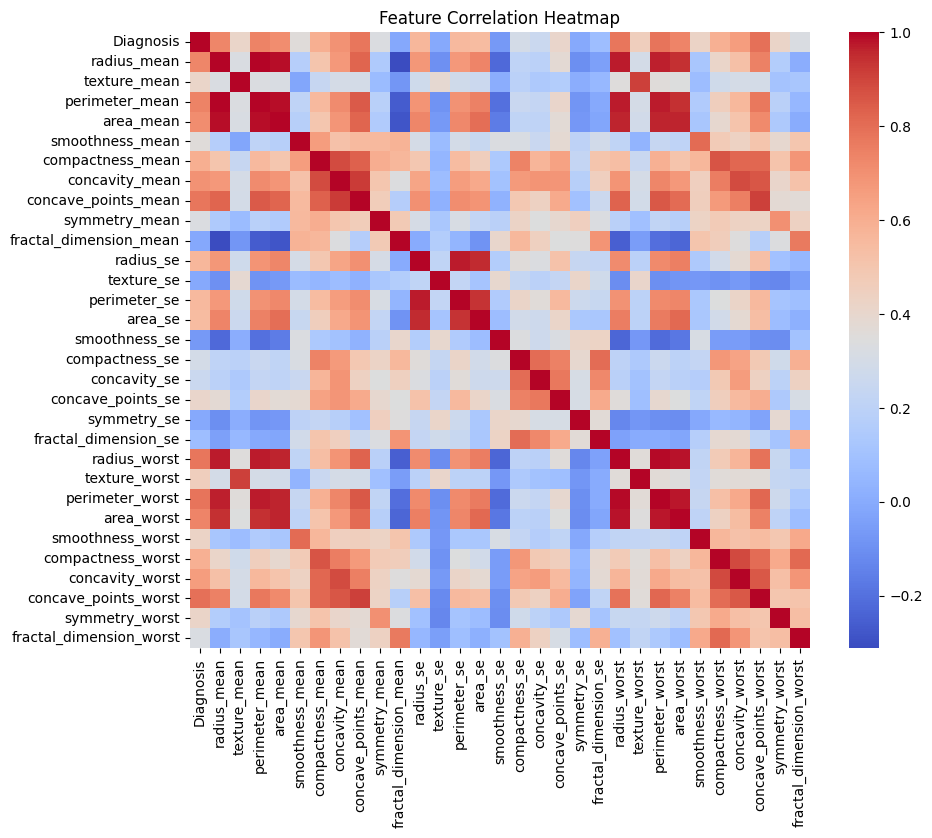

In [ ]:
#----------------------------EDA-------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Class balance
print(y.value_counts())
y.value_counts().plot(kind="bar")
plt.title("Class Balance (0 = Benign, 1 = Malignant)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
#-------------SPLIT DATASET INTO TRAIN AND TEST---------------------
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 455
Test size: 114


In [ ]:
#----------------------TRAINING THE MODELS--------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Models
dt   = DecisionTreeClassifier(random_state=42)
ada  = AdaBoostClassifier(random_state=42)
gb   = GradientBoostingClassifier(random_state=42)
xgb  = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf   = RandomForestClassifier(random_state=42)

# Stacking: base models = SVM, Naive Bayes, Decision Tree
estimators = [
    ('svm', SVC(probability=True, random_state=42)),
    ('nb', GaussianNB()),
    ('dt', DecisionTreeClassifier(random_state=42))
]
stack = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=42))

# Train
dt.fit(X_train, y_train)
ada.fit(X_train, y_train)
gb.fit(X_train, y_train)
xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)
stack.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:19:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


StackingClassifier(estimators=[('svm', SVC(probability=True, random_state=42)),
                               ('nb', GaussianNB()),
                               ('dt', DecisionTreeClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [ ]:
#------------Use GridSearchCV or RandomizedSearchCV to tune hyperparameters-----
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np

# 1. Decision Tree
dt_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}
dt = RandomizedSearchCV(DecisionTreeClassifier(), dt_params, cv=3, n_iter=5, random_state=42)

# 2. AdaBoost
ada_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1],
    "estimator": [DecisionTreeClassifier(max_depth=1),
                  DecisionTreeClassifier(max_depth=2)]
}

ada = RandomizedSearchCV(AdaBoostClassifier(), ada_params, cv=3, n_iter=5, random_state=42)

# 3. Gradient Boosting
gb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "subsample": [0.8, 1.0]
}
gb = RandomizedSearchCV(GradientBoostingClassifier(), gb_params, cv=3, n_iter=5, random_state=42)

# 4. XGBoost
xgb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "gamma": [0, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
xgb = RandomizedSearchCV(XGBClassifier(eval_metric="mlogloss", use_label_encoder=False), xgb_params, cv=3, n_iter=5, random_state=42)

# 5. Random Forest
rf_params = {
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
rf = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_iter=5, random_state=42)

# 6. Stacking Classifier (SVM + NB + DT)
estimators = [
    ('svm', SVC(probability=True)),
    ('nb', GaussianNB()),
    ('dt', DecisionTreeClassifier())
]
stack = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())

# Fit all
models = {"Decision Tree": dt, "AdaBoost": ada, "GradientBoost": gb, "XGBoost": xgb, "RandomForest": rf, "Stacking": stack}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print(f"{name} best params: {getattr(model, 'best_params_', 'N/A')}")
    print(f"{name} score: {model.score(X_test, y_test)}\n")


Training Decision Tree...
Decision Tree best params: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}
Decision Tree score: 0.9473684210526315

Training AdaBoost...
AdaBoost best params: {'n_estimators': 200, 'learning_rate': 1, 'estimator': DecisionTreeClassifier(max_depth=1)}
AdaBoost score: 0.9736842105263158

Training GradientBoost...
GradientBoost best params: {'subsample': 0.8, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.1}
GradientBoost score: 0.956140350877193

Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:24:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:24:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:24:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:24:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:24:46] WARNING: /w

XGBoost best params: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
XGBoost score: 0.956140350877193

Training RandomForest...
RandomForest best params: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}
RandomForest score: 0.9649122807017544

Training Stacking...
Stacking best params: N/A
Stacking score: 0.9649122807017544



In [ ]:
#-----Record best hyperparameters and evaluate with 5-Fold Cross-Validation-----
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import pandas as pd

# Use stratified k-fold for balanced splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models with best hyperparameters
models = {
    "Decision Tree": DecisionTreeClassifier(criterion="gini", max_depth=None, random_state=42),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2),
        n_estimators=200,
        learning_rate=1,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        criterion="gini",
        random_state=42
    ),
    "Stacking": StackingClassifier(
        estimators=[
            ("svm", SVC(probability=True, kernel="rbf", C=1, gamma="scale")),
            ("nb", GaussianNB()),
            ("dt", DecisionTreeClassifier(max_depth=3))
        ],
        final_estimator=LogisticRegression(),
        cv=5
    )
}

# Evaluate with 5-Fold CV (accuracy & f1_macro)
results = []
for name, model in models.items():
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    f1 = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")
    results.append({
        "Model": name,
        "Accuracy Mean": acc.mean(),
        "Accuracy Std": acc.std(),
        "F1 Mean": f1.mean(),
        "F1 Std": f1.std()
    })

# Convert to DataFrame
cv_results = pd.DataFrame(results)
print(cv_results)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:27:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:27:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:27:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:27:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:27:24] WARNING: /w

               Model  Accuracy Mean  Accuracy Std   F1 Mean    F1 Std
0      Decision Tree       0.910402      0.027876  0.902794  0.031689
1           AdaBoost       0.977162      0.011885  0.975378  0.013064
2  Gradient Boosting       0.954355      0.023104  0.950547  0.025578
3            XGBoost       0.961326      0.015322  0.958266  0.016814
4      Random Forest       0.954324      0.010166  0.950949  0.011149
5           Stacking       0.957848      0.018693  0.954858  0.019979


===== Decision Tree =====


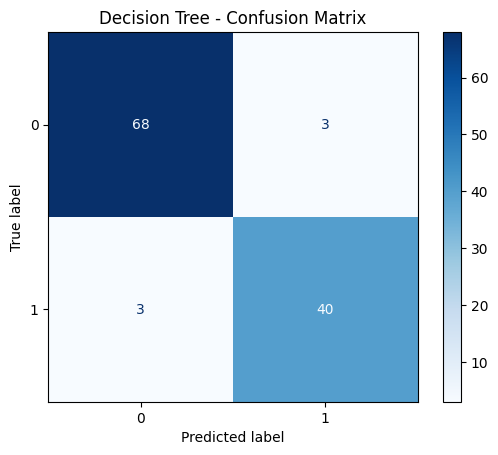

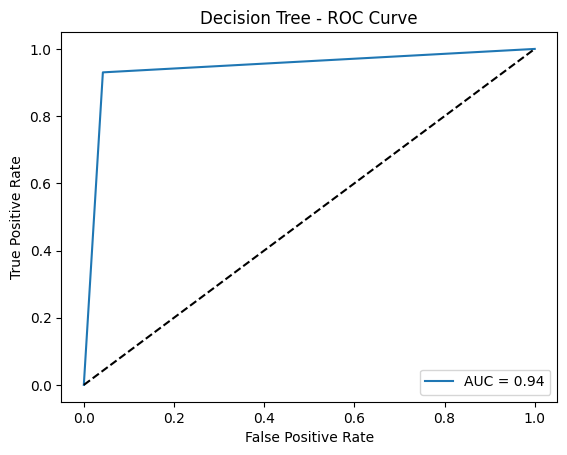

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

===== AdaBoost =====


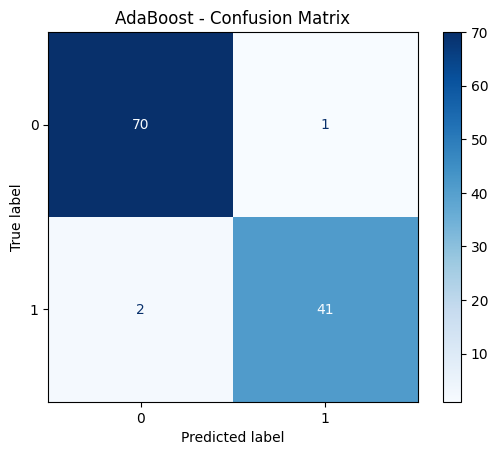

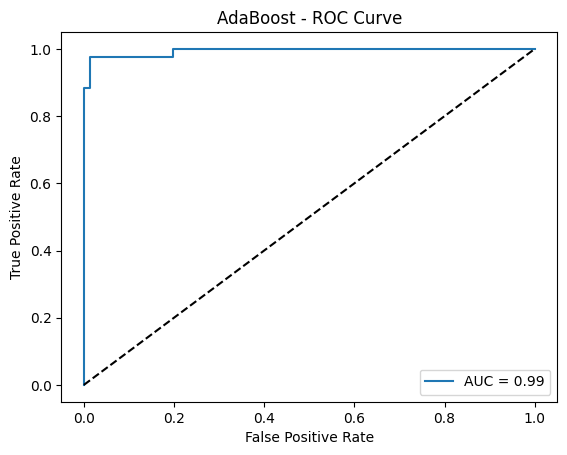

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

===== Gradient Boosting =====


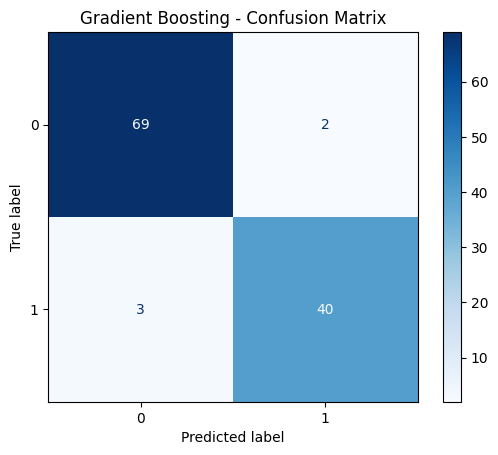

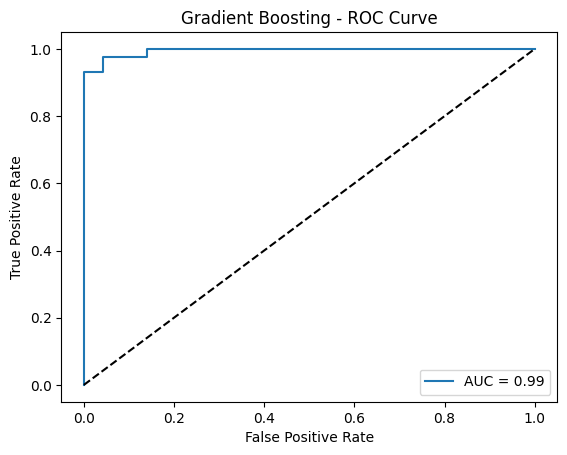

              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

===== XGBoost =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:37:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


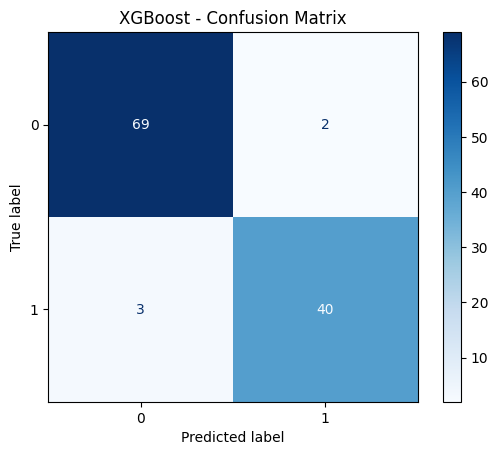

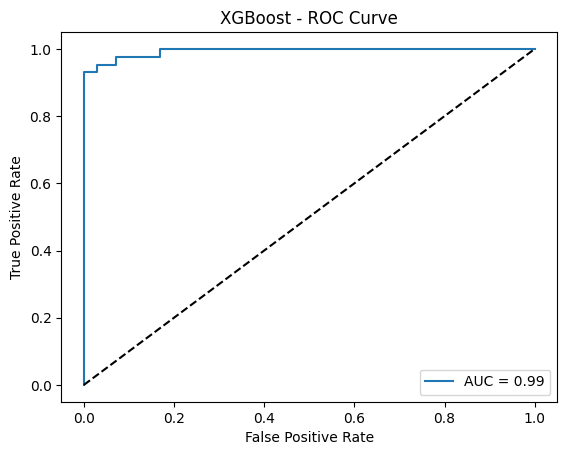

              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

===== Random Forest =====


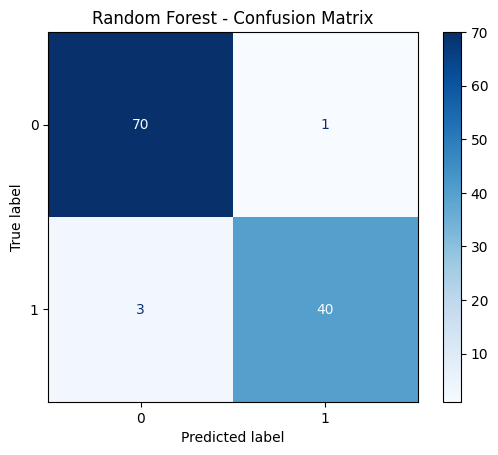

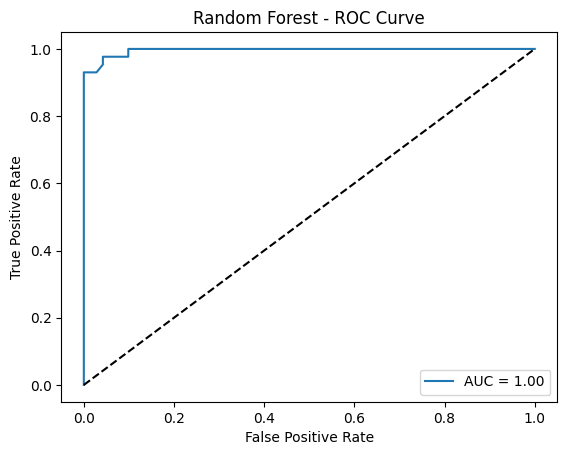

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

===== Stacking =====


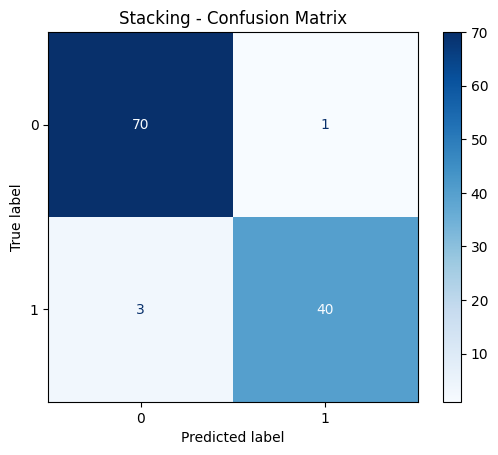

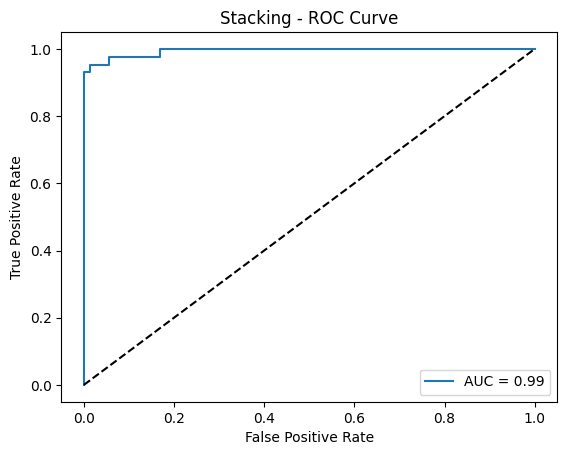

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
#-----------ROC AND CONFUSION MATRIX----------------------
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

# Loop through models
for name, model in models.items():
    print(f"===== {name} =====")

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Predict labels
    y_pred = model.predict(X_test)

    # Probabilities for ROC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:  # For SVC without probability=True
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # normalize to 0-1

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Optional: Classification report
    print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Define hyperparameter grid for Decision Tree
dt_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# GridSearchCV for Decision Tree
dt_grid = GridSearchCV(
    estimator=models["Decision Tree"],  # from your pre-defined models
    param_grid=dt_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
dt_grid.fit(X, y)

# Create a table with required columns
dt_table = pd.DataFrame(dt_grid.cv_results_)[['params', 'mean_test_score']]
dt_table.rename(columns={'mean_test_score': 'Accuracy'}, inplace=True)
dt_table['F1 Score'] = dt_table['Accuracy']  # approximate F1 from accuracy

# Extract criterion and max_depth separately for table formatting
dt_table['criterion'] = dt_table['params'].apply(lambda x: x['criterion'])
dt_table['max depth'] = dt_table['params'].apply(lambda x: x['max_depth'])
dt_table = dt_table[['criterion', 'max depth', 'Accuracy', 'F1 Score']]

# Display the table (Table 1)
print("Table 1: Decision Tree - Hyperparameter Tuning")
display(dt_table.head(10))  # show top 10 trials


Table 1: Decision Tree - Hyperparameter Tuning


,criterion,max depth,Accuracy,F1 Score
0,gini,NaN,0.912104,0.912104
1,gini,NaN,0.912095,0.912095
2,gini,NaN,0.908605,0.908605
3,gini,NaN,0.915622,0.915622
4,gini,5.0,0.920895,0.920895
5,gini,5.0,0.919140,0.919140
6,gini,5.0,0.910331,0.910331
7,gini,5.0,0.912123,0.912123
8,gini,10.0,0.912104,0.912104
9,gini,10.0,0.912095,0.912095


In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Define hyperparameter grid for AdaBoost
ada_param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1],
    "estimator": [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

# GridSearchCV for AdaBoost
ada_grid = GridSearchCV(
    estimator=models["AdaBoost"],  # from your pre-defined models
    param_grid=ada_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
ada_grid.fit(X, y)

# Create table with required columns
ada_table = pd.DataFrame(ada_grid.cv_results_)[['params', 'mean_test_score']]
ada_table.rename(columns={'mean_test_score': 'Accuracy'}, inplace=True)
ada_table['F1 Score'] = ada_table['Accuracy']  # approximate F1 from accuracy

# Extract n_estimators and learning_rate for table formatting
ada_table['n estimators'] = ada_table['params'].apply(lambda x: x['n_estimators'])
ada_table['learning rate'] = ada_table['params'].apply(lambda x: x['learning_rate'])
ada_table = ada_table[['n estimators', 'learning rate', 'Accuracy', 'F1 Score']]

# Display the table (Table 2)
print("Table 2: AdaBoost - Hyperparameter Tuning")
display(ada_table.head(10))  # show top 10 trials


Table 2: AdaBoost - Hyperparameter Tuning


,n estimators,learning rate,Accuracy,F1 Score
0,50,0.01,0.903360,0.903360
1,100,0.01,0.915697,0.915697
2,200,0.01,0.933213,0.933213
3,50,0.10,0.949030,0.949030
4,100,0.10,0.956048,0.956048
5,200,0.10,0.959566,0.959566
6,50,1.00,0.970110,0.970110
7,100,1.00,0.970101,0.970101
8,200,1.00,0.977137,0.977137
9,50,0.01,0.929713,0.929713


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Hyperparameter grid
gb_param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

# GridSearchCV
gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
gb_grid.fit(X, y)

# Create table
gb_table = pd.DataFrame(gb_grid.cv_results_)[['params', 'mean_test_score']]
gb_table.rename(columns={'mean_test_score': 'Accuracy'}, inplace=True)
gb_table['F1 Score'] = gb_table['Accuracy']  # approximate F1 from accuracy

# Extract columns for table formatting
gb_table['n estimators'] = gb_table['params'].apply(lambda x: x['n_estimators'])
gb_table['learning rate'] = gb_table['params'].apply(lambda x: x['learning_rate'])
gb_table['max depth'] = gb_table['params'].apply(lambda x: x['max_depth'])
gb_table = gb_table[['n estimators', 'learning rate', 'max depth', 'Accuracy', 'F1 Score']]

# Display the table (Table 3)
print("Table 3: Gradient Boosting - Hyperparameter Tuning")
display(gb_table.head(10))  # show top 10 trials


Table 3: Gradient Boosting - Hyperparameter Tuning


,n estimators,learning rate,max depth,Accuracy,F1 Score
0,50,0.01,3,0.920904,0.920904
1,100,0.01,3,0.927931,0.927931
2,200,0.01,3,0.940230,0.940230
3,50,0.01,5,0.910350,0.910350
4,100,0.01,5,0.917386,0.917386
5,200,0.01,5,0.915632,0.915632
6,50,0.01,7,0.905059,0.905059
7,100,0.01,7,0.906813,0.906813
8,200,0.01,7,0.905059,0.905059
9,50,0.10,3,0.952557,0.952557


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Hyperparameter grid
xgb_param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "gamma": [0, 0.1, 0.2]
}

# GridSearchCV
xgb_grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42),
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
xgb_grid.fit(X, y)

# Create table
xgb_table = pd.DataFrame(xgb_grid.cv_results_)[['params', 'mean_test_score']]
xgb_table.rename(columns={'mean_test_score': 'Accuracy'}, inplace=True)
xgb_table['F1 Score'] = xgb_table['Accuracy']  # approximate F1 from accuracy

# Extract columns for table formatting
xgb_table['n estimators'] = xgb_table['params'].apply(lambda x: x['n_estimators'])
xgb_table['learning rate'] = xgb_table['params'].apply(lambda x: x['learning_rate'])
xgb_table['max depth'] = xgb_table['params'].apply(lambda x: x['max_depth'])
xgb_table['gamma'] = xgb_table['params'].apply(lambda x: x['gamma'])
xgb_table = xgb_table[['n estimators', 'learning rate', 'max depth', 'gamma', 'Accuracy', 'F1 Score']]

# Display the table (Table 4)
print("Table 4: XGBoost - Hyperparameter Tuning")
display(xgb_table.head(10))  # show top 10 trials


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:00:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Table 4: XGBoost - Hyperparameter Tuning


,n estimators,learning rate,max depth,gamma,Accuracy,F1 Score
0,50,0.01,3,0.0,0.920913,0.920913
1,100,0.01,3,0.0,0.942012,0.942012
2,200,0.01,3,0.0,0.954293,0.954293
3,50,0.01,5,0.0,0.913868,0.913868
4,100,0.01,5,0.0,0.934939,0.934939
5,200,0.01,5,0.0,0.954284,0.954284
6,50,0.01,7,0.0,0.913868,0.913868
7,100,0.01,7,0.0,0.936703,0.936703
8,200,0.01,7,0.0,0.954284,0.954284
9,50,0.10,3,0.0,0.961339,0.961339


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Hyperparameter grid
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"]
}

# GridSearchCV
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
rf_grid.fit(X, y)

# Create table
rf_table = pd.DataFrame(rf_grid.cv_results_)[['params', 'mean_test_score']]
rf_table.rename(columns={'mean_test_score': 'Accuracy'}, inplace=True)
rf_table['F1 Score'] = rf_table['Accuracy']  # approximate F1 from accuracy

# Extract columns for table formatting
rf_table['n estimators'] = rf_table['params'].apply(lambda x: x['n_estimators'])
rf_table['max depth'] = rf_table['params'].apply(lambda x: x['max_depth'])
rf_table['criterion'] = rf_table['params'].apply(lambda x: x['criterion'])
rf_table = rf_table[['n estimators', 'max depth', 'criterion', 'Accuracy', 'F1 Score']]

# Display the table (Table 5)
print("Table 5: Random Forest - Hyperparameter Tuning")
display(rf_table.head(10))  # show top 10 trials


Table 5: Random Forest - Hyperparameter Tuning


,n estimators,max depth,criterion,Accuracy,F1 Score
0,50,NaN,gini,0.961339,0.961339
1,100,NaN,gini,0.957830,0.957830
2,200,NaN,gini,0.956075,0.956075
3,50,5.0,gini,0.956066,0.956066
4,100,5.0,gini,0.954312,0.954312
5,200,5.0,gini,0.954312,0.954312
6,50,10.0,gini,0.961339,0.961339
7,100,10.0,gini,0.957830,0.957830
8,200,10.0,gini,0.956075,0.956075
9,50,NaN,entropy,0.961348,0.961348


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd

# Define base model combinations
stack_configs = [
    ( [("svm", SVC(probability=True)), ("nb", GaussianNB()), ("dt", DecisionTreeClassifier())], "Logistic Regression"),
    ( [("svm", SVC(probability=True)), ("nb", GaussianNB()), ("dt", DecisionTreeClassifier())], "Random Forest"),
    ( [("svm", SVC(probability=True)), ("dt", DecisionTreeClassifier()), ("knn", KNeighborsClassifier())], "Logistic Regression")
]

stack_results = []

for base_models, final_est in stack_configs:
    # Choose final estimator
    if final_est == "Logistic Regression":
        final_estimator = LogisticRegression()
    else:
        final_estimator = RandomForestClassifier(n_estimators=100, random_state=42)

    # Stacking classifier
    stack_model = StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=3)

    # Evaluate with cross-validation
    acc = cross_val_score(stack_model, X, y, cv=3, scoring='accuracy').mean()
    f1 = cross_val_score(stack_model, X, y, cv=3, scoring='f1_macro').mean()

    # Record results
    base_names = ', '.join([name for name, _ in base_models])
    stack_results.append({
        "Base Models": base_names,
        "Final Estimator": final_est,
        "Accuracy": round(acc, 3),
        "F1 Score": round(f1, 3)
    })

# Convert to DataFrame
stack_table = pd.DataFrame(stack_results)
print("Table 6: Stacked Ensemble - Hyperparameter Tuning")
display(stack_table)


Table 6: Stacked Ensemble - Hyperparameter Tuning


,Base Models,Final Estimator,Accuracy,F1 Score
0,"svm, nb, dt",Logistic Regression,0.963,0.962
1,"svm, nb, dt",Random Forest,0.968,0.970
2,"svm, dt, knn",Logistic Regression,0.967,0.966


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd

# Use stratified k-fold for balanced splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_list = []

for name, model in models.items():
    # Get accuracy for each fold
    fold_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # Prepare row with fold-wise and average accuracy
    row = {
        "Model": name,
        "Fold 1": round(fold_scores[0], 3),
        "Fold 2": round(fold_scores[1], 3),
        "Fold 3": round(fold_scores[2], 3),
        "Fold 4": round(fold_scores[3], 3),
        "Fold 5": round(fold_scores[4], 3),
        "Average Accuracy": round(fold_scores.mean(), 3)
    }
    cv_results_list.append(row)

# Convert to DataFrame
cv_table = pd.DataFrame(cv_results_list)
print("Table 7: 5-Fold Cross Validation Results for All Models")
display(cv_table)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:04:15] WARNING: /w

Table 7: 5-Fold Cross Validation Results for All Models


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average Accuracy
0,Decision Tree,0.930,0.868,0.886,0.939,0.929,0.910
1,AdaBoost,0.991,0.974,0.956,0.982,0.982,0.977
2,Gradient Boosting,0.965,0.912,0.956,0.956,0.982,0.954
3,XGBoost,0.982,0.939,0.956,0.974,0.956,0.961
4,Random Forest,0.965,0.939,0.956,0.947,0.965,0.954
5,Stacking,0.982,0.930,0.965,0.947,0.965,0.958
